<a href="https://colab.research.google.com/github/workingbetter/ITNPAI1/blob/main/ITNPAI1_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

# ITNPAI1 Project
MICHAEL BOGALE
3071806

---
# 1. Problem Defination
## Image Classification problem
Creating a deep learning model that classifies cars and trees on image dataset collected from Areal imaging on Google Earth Pro and testing its performance.
## Dataset collected 
Addis Ababa 

Stirling

---
# 2. Github repository
repository created

###Invitation sent usernames

1. sandyCarmichael
2. vak000
3. jeferssonalex

---
# 3. Dataset Creation
##Created dataset containing 400 images on each subset
## Addis Ababa Labeled Images
####Addis Ababa Car (400)
####Addis Ababa Tree (400)
####Addis Ababa Neither (400)
## Stirling Labeled Images
####Stirling Car (400)
####Stirling Tree (400)
####Stirling Neither (400)




---
# 4. Dataloader
1. Pre processing
2. Cleaning
3. De-noising

## 4.1. Pre processing

labeling Dataframe function created

extracting to csv line utilized

label csv is created for easier access

In [52]:
import os
import pandas as pd
"""the dataset is locate on my drive therefore it can not be accessed directly from github
may be i will find a way to access the zip file in github later """

# Directory path Image dataset
stir_path = "/content/drive/MyDrive/Deep learning/dataset/Stirling Labeled/"
addis_path = "/content/drive/MyDrive/Deep learning/dataset/Addis Ababa Labeled/"

# Defining a function for generating dataframe of lables 
def labeler_csv(path):
  data = []
  for folder in os.listdir(path):
      for file in os.listdir(os.path.join(path, folder)):
        if file != '.DS_Store':
          data.append([os.path.join(folder, file), folder])
  df = pd.DataFrame(data, columns=['filename', 'label'])
  # df.to_csv('/content/drive/MyDrive/Stirling_labels.csv', index=False)
  return(df)

display(labeler_csv(stir_path))

,filename,label
0,car/image1_1x13.jpg,car
1,car/image1_3x10.jpg,car
2,car/image1_3x11.jpg,car
3,car/image1_7x1.jpg,car
4,car/image1_7x29.jpg,car
...,...,...
1195,tree/image9_8x30.jpg,tree
1196,tree/image10_1x13.jpg,tree
1197,tree/image10_1x11.jpg,tree
1198,tree/image10_1x14.jpg,tree


In [53]:
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize the images to 224x224
    transforms.ToTensor(), # convert the images to PyTorch tensors
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize the images
])

# Define the dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        
        # Load the image paths and labels from the two folders
        for label in ['0', '1']:
            folder_path = f'{root_dir}/{label}/'
            for image_path in os.listdir(folder_path):
                self.image_paths.append(f'{folder_path}/{image_path}')
                self.labels.append(int(label))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load the image and apply the transformations
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = transform(image)
        
        # Get the label of the image
        label = self.labels[idx]
        
        return image, label



In [54]:
# Define plotting function
def plot_dataset(positive, negative):
    labels_map = {
        0: negative,
        1: positive
    }

    # Selecting some images for preview
    figure = plt.figure(figsize=(8, 4))
    cols, rows = 5, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item() # Randomly selected
        #print(sample_idx)
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        new_img = np.transpose(img, (1, 2, 0))
        plt.imshow(new_img.squeeze())
    plt.show()

### Stirling Tree

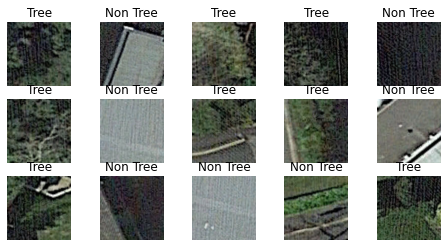

In [55]:
# Create the dataset and dataloader objects
dataset_loc = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Stirling_Tree'

dataset = CustomDataset(dataset_loc)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

plot_dataset("Tree", "Non Tree")

### Stirling Car

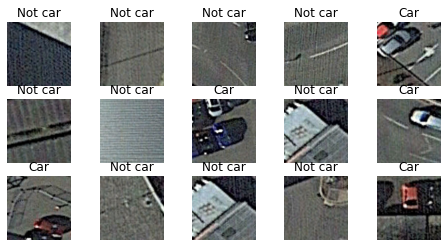

In [56]:
# Create the dataset and dataloader objects
dataset_loc = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Stirling_Car'

dataset = CustomDataset(dataset_loc)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

plot_dataset("Car", "Not car")

### Addis Ababa Tree

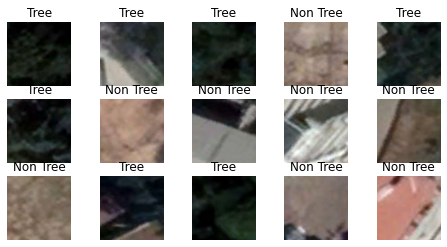

In [57]:
# Create the dataset and dataloader objects
dataset_loc = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Addis_Ababa_Tree'

dataset = CustomDataset(dataset_loc)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

plot_dataset("Tree", "Non Tree")

### Addis Ababa Car

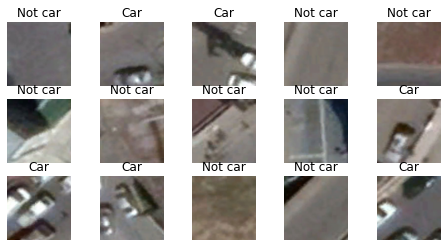

In [58]:
# Create the dataset and dataloader objects
dataset_loc = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Addis_Ababa_Car'

dataset = CustomDataset(dataset_loc)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

plot_dataset("Car", "Not car")